# Forest Cover Type Prediction
#### Team: Clear-Cut Solution: Kevin Martin, Yang Jing, Justine Schabel

TODO: Introduce the project 

## Initial Setup
#### Import Required Libraries

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Libraries for reading, cleaning and plotting the dataa
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

# Feature Engineering was written by the team 
import feature_engineering as fe
# Models was written by the team 
import models 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

#### Load Data

In [2]:
# Read in training data 
train_df = pd.read_csv("data/train.csv")

## Feature Engineering 
The following transformations were made in the function below. 

#### Transform Hillshade
Now we'll normalize the "Hillsdale" variables by dividing them by 255. The hillshade variables contain index of shades with a value between 0 and 255. 

#### Create new soil types
Now we'll create additional features to magnify the differences betweeen cover type1 and 2, and covery type3 and 6.

#### Combine soil types 

#### Drop rare or non-existant soil types 
Now we'll drop soil types that don't exist in the training set. Then we will combine soil types 35, 38, 39 and 40 because they have a very similar distribution. 

#### Create new features based on soil type descriptions 
TODO: Explain how we split up soil descriptions into different features to account for overlap.

#### Transform Aspect
TODO: Explain aspect problem and solution

#### Log transformations
TODO: Now we'll log transform the features related to the distances. (explain why)

#### Add polynomial features
TODO: Explain why we're making Elevation polynomial

#### Drop irrelevant or problematic features
- We'll drop "Id" because it does not provide any meaning in the classifications.
- We'll drop "Hillshade_9am" because it has a high correlation with "Aspect" and "Hillshade_3pm".
- TODO: We'll also drop "Vertical_Distance_To_Hydrology" because _.


In [4]:
def manipulate_data(data):
    """ 
    This function applys transformations on the input data set
    
    Parameters: 
        data (dataframe): n_examples x m_features (int64) dataframe 
    """
    data = fe.scale_hillside(data)
    
    # Soil Combination One (based on distributions)
    data = fe.combine_environment_features(data)
    data = fe.drop_unseen_soil_types(data)  
    data = fe.combine_soil_types(data)
      
    
    # Soil Combination Two (based on descriptions)
    # data = fe.set_soil_type_by_attributes(data)
    
    data = fe.transform_aspect(data)
    
    features_to_log = ['Horizontal_Distance_To_Hydrology',
           'Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points']
    data = fe.log_features(data, features_to_log)
    
    features_to_square = ["Elevation"]
    data = fe.add_polynomial_features(data, features_to_square)

    # These are already being dropped by now? 
    features_to_drop = ["Id","Hillshade_9am","Vertical_Distance_To_Hydrology"]
    data = fe.drop_features(data, features_to_drop)
    
    return data

train_df = manipulate_data(train_df)

#### Examine transformed data

In [5]:
train_df.describe()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,...,type6st,soil_type35383940,st10111617,st912,st3133,st2324,st6w4,ap_ew,ap_ns,Elevation_squared
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,1.512000e+04
mean,2749.322553,16.501587,4.645584,7.124224,0.858689,0.529773,7.058263,0.237897,0.033003,0.419907,...,0.140410,0.128704,0.216534,0.015675,0.062698,0.067063,0.352183,0.226527,0.146622,7.733218e+06
std,417.678187,8.453927,1.805867,0.875852,0.089419,0.179981,0.776280,0.425810,0.178649,0.493560,...,0.347423,0.334883,0.411896,0.124217,0.242428,0.250140,0.560491,0.676366,0.685404,2.315859e+06
min,1863.000000,0.000000,0.000000,0.000000,0.388235,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,3.470769e+06
25%,2376.000000,10.000000,4.219508,6.639876,0.811765,0.415686,6.594413,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.390731,-0.500000,5.645376e+06
50%,2752.000000,15.000000,5.198497,7.183112,0.874510,0.541176,7.136483,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.406737,0.275637,7.573504e+06
75%,3104.000000,22.000000,5.802118,7.727976,0.921569,0.654902,7.595513,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.866025,0.809017,9.634816e+06
max,3849.000000,52.000000,7.203406,8.837971,0.996078,0.972549,8.852808,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.481480e+07


Now that the data is transformed, we can also visualize the new aspect features. 

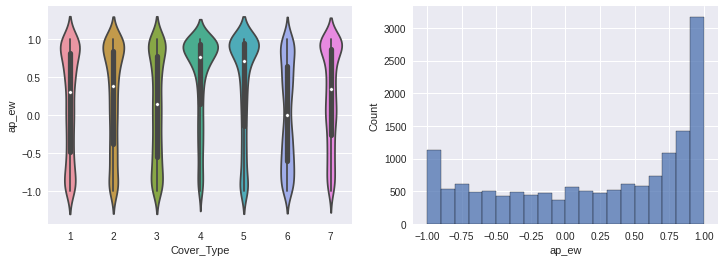

In [6]:
# Visualize cover type VS the cosine of Aspect degerees
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
sns.violinplot(x=train_df['Cover_Type'],y=train_df['ap_ew'],ax=ax1)
sns.histplot(train_df['ap_ew'],ax=ax2)
plt.show()

After the feature transformation, we see improved distinction in median values, espeically for cover type 6, where the median is notably higher than that of other cover types and the distribution is concentrated around the median.

#### Split data into train/dev

Then, we split the training data into a training data set (80%) and development data set (20%). We will also have a large, separate test data set. 

In [7]:
train_data, train_labels, dev_data, dev_labels = fe.split_data(train_df)

#### Scale the data to have a mean of 0 and a variance of 1.

In [8]:
standardize_features = ['Elevation','Slope', 'Horizontal_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points','Elevation_squared']
train_data, train_scaler = fe.scale_training_data(standardize_features, train_data, scaler_type="standard")
dev_data = fe.scale_non_training_data(standardize_features, dev_data, train_scaler)

#### Explore and confirm the shape of the data

In [9]:
print("Training data shape: {0} Training labels shape: {1}\n".format(train_data.shape, train_labels.shape))
print("Dev data shape: {0} Dev labels shape: {1}\n".format(dev_data.shape, dev_labels.shape))

Training data shape: (12096, 52) Training labels shape: (12096,)

Dev data shape: (3024, 52) Dev labels shape: (3024,)



## Models

#### Random Forest

Random Forest Performance for 1 trees: 0.6921296296296297
Mean Squared Error:  2.8488756613756614
Random Forest Performance for 3 trees: 0.7199074074074074
Mean Squared Error:  2.6392195767195767
Random Forest Performance for 5 trees: 0.7423941798941799
Mean Squared Error:  2.447089947089947
Random Forest Performance for 10 trees: 0.7622354497354498
Mean Squared Error:  2.2116402116402116
Random Forest Performance for 100 trees: 0.7731481481481481
Mean Squared Error:  1.9583333333333333


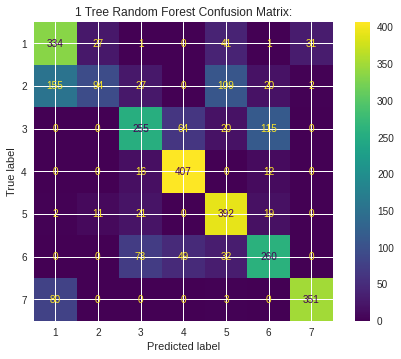

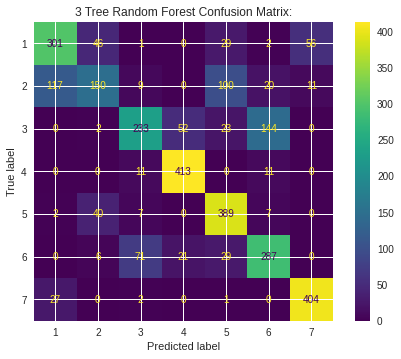

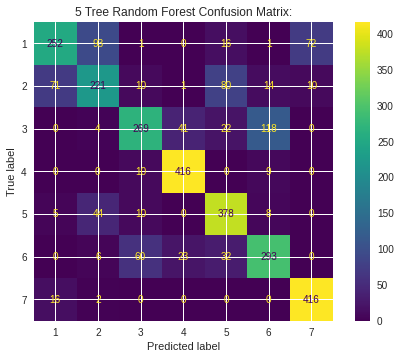

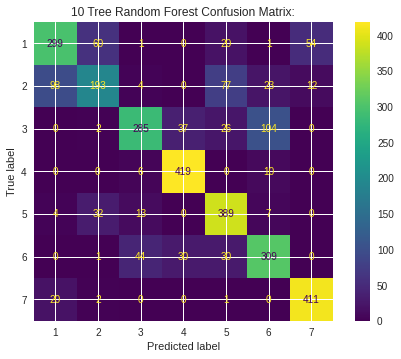

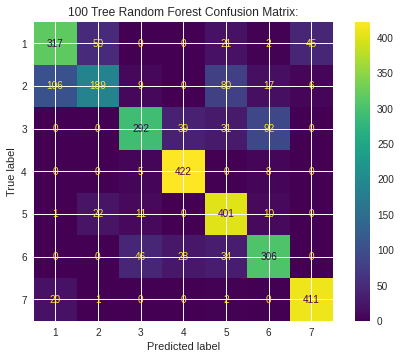

In [10]:
num_trees_list = [1,3,5,10,100]
random_forest_models = []
random_forest_results = {}
for num_trees in num_trees_list:
    score, probabilities, random_forest_model = models.random_forest(num_trees, train_data, train_labels, dev_data, dev_labels)
    random_forest_results[score] = probabilities
    random_forest_models.append(random_forest_model)

#### K-Nearest Neighbors

KNN 1 neighbors : accuracy = 0.8382936507936508
Mean Squared Error:  1.5787037037037037
KNN 2 neighbors : accuracy = 0.8177910052910053
Mean Squared Error:  1.6762566137566137
KNN 4 neighbors : accuracy = 0.8244047619047619
Mean Squared Error:  1.6683201058201058
KNN 7 neighbors : accuracy = 0.8148148148148148
Mean Squared Error:  1.8075396825396826
KNN 10 neighbors : accuracy = 0.8115079365079365
Mean Squared Error:  1.8323412698412698


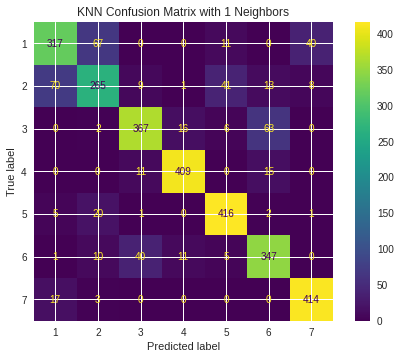

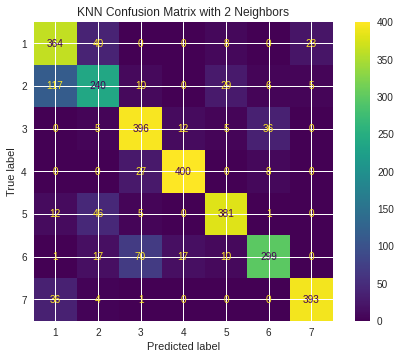

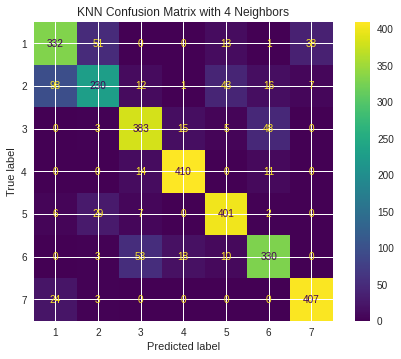

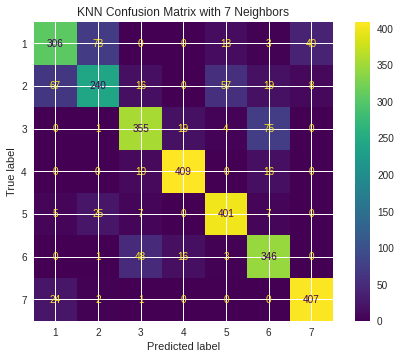

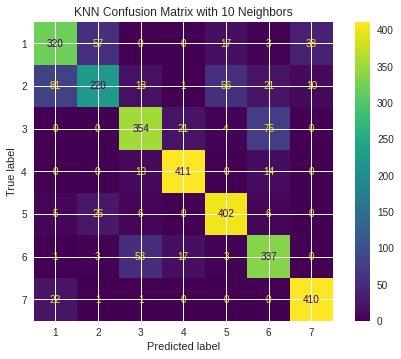

In [11]:
neighbor_list = [1,2,4, 7, 10]
knn_models = []
knn_results = {}
for neighbor in neighbor_list:
    score, probabilities, knn_model = models.k_nearest_neighbors(neighbor,train_data, train_labels, dev_data, dev_labels)
    knn_results[score] = probabilities
    knn_models.append(knn_model)
    

#### Multi-Layer Perceptron

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP accuracy =  0.8472222222222222
Mean Squared Error:  1.3892195767195767


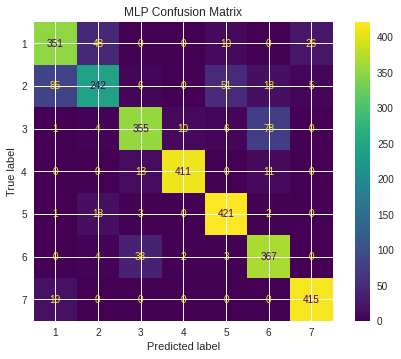

In [12]:
mlp_results = {}
score, probabilities,mlp_model = models.multi_layer_perceptron(train_data, train_labels, dev_data, dev_labels)
mlp_results[score] = probabilities 

#### Logistic Regression

In [13]:
models.logistic_regression(train_data, train_labels, dev_data, dev_labels)

Logistic Regression accuracy =  0.6990740740740741


#### Neural Network 

In [14]:
# models.neural_network(train_data, train_labels, dev_data, dev_labels)

#### Ensemble
Here we will combine the three best performing models and implement a "voting" system to try to improve accuracy.

In [15]:
predicted_classes, new_predictions = models.ensemble(mlp_results,knn_results,random_forest_results, dev_labels)
mse_ensemble = mean_squared_error(dev_labels, new_predictions)
accuracy = accuracy_score(dev_labels, new_predictions)
print("Mean Squared Error: ", mse_ensemble)
print("Accuracy: ", accuracy)

Models disagreed on 2966/3024 dev examples.
Mean Squared Error:  2.4712301587301586
Accuracy:  0.7886904761904762


#### Examine and Compare Histograms of Predictions

(array([444., 262., 363., 489., 569., 435., 462.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

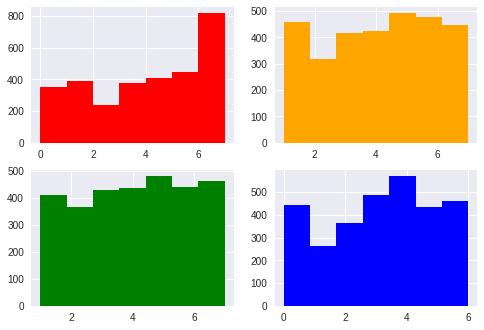

In [16]:
fig, axes = plt.subplots(2,2)
# Ensemble
axes[0,0].hist(new_predictions, bins=7,color = 'red') 
# MLP
axes[0,1].hist(predicted_classes[:,0], bins=7, color = 'orange') 
# KNN
axes[1,0].hist(predicted_classes[:,1], bins=7, color = 'green') 
# Random Forest
axes[1,1].hist(predicted_classes[:,2], bins=7, color = 'blue') 

## Test Results
#### Read in test data

In [17]:
# Read in training data 
test_data = pd.read_csv("data/test.csv")
# Preserve testing df ID for submission purpose
test_df_ID = test_data["Id"]

#### Apply the same transformations

In [18]:
test_data = manipulate_data(test_data)
test_data = fe.scale_non_training_data(standardize_features, test_data, train_scaler)

In [19]:
random_forest_predictions = random_forest_models[-1].predict(test_data)
knn_predictions = knn_models[0].predict(test_data)
mlp_predictions = mlp_model.predict(test_data)

#### Generate Submission File

In [20]:
def gen_submission(y_pred,model):
    result = pd.DataFrame.from_dict(dict(zip(test_df_ID.to_list(),y_pred)), orient='index', columns=["Cover_Type"])
    result.to_csv(f"submissions/submission{model}.csv",index_label="Id")

gen_submission(random_forest_predictions, model="RandomForest")
gen_submission(knn_predictions, model="KNN")
gen_submission(mlp_predictions, model="MLP")

### End matter

#### Acknowledgements/Sources

* That helpful stack overflow post
  * https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
* Relevant Documentation
  * KNeighborsClassifier
    * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
  * Pretty Confusion Matrix
    * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
  * Preprocessing
    * https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
* Soil information
  * https://www.uidaho.edu/cals/soil-orders/aridisols
  
#### Backup Formats

*because sometimes you just want to look at the markdown or whatever real quick*

In [21]:
#Create a backup of the jupyter notebook in a format for where changes are easier to see.
!jupyter nbconvert clear_cut_solution.ipynb --to="python" --output="backups/clear_cut_solution"
!jupyter nbconvert clear_cut_solution.ipynb --to markdown --output="backups/clear_cut_solution"

# Also archiving this bad boy
!jupyter nbconvert clear_cut_solution.ipynb --to html --output="backups/clear_cut_solution"

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook clear_cut_solution.ipynb to python
[NbConvertApp] Writing 9288 bytes to backups/clear_cut_solution.py
[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook clear_cut_solution.ipynb to markdown
[NbConvertApp] Writing 9695 bytes to backups/clear_cut_solution.md
[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook clear_cut_solution.ipynb to html
[NbConvertApp] Writing 313111 bytes to backups/clear_cut_solution.html
